In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm,t
# from scipy.optimize import minimize
import statsmodels.api as sm

# Daily_return = pd.read_csv("DailyReturn.csv")
# Daily_return=Daily_return.rename(columns={"Unnamed: 0": "Date"})
Daily_Price = pd.read_csv("DailyPrices.csv")
portfolio= pd.read_csv("portfolio.csv")


In [ ]:
# Problem 1

def generate_Classical_Brownian_Motion(sigma,t,p0):
    p=[]
    r=[]
    p.append(p0)
    
    for i in range(t):
        rt=np.random.normal(0,sigma)
        r.append(rt)
        tmp=p[i]+rt
        p.append(tmp)
    
    print("The Classical Brownian Motion's result:")
    print("Mean:"+ str(np.mean(p)))
    print("Standard deviation:"+ str(np.std(p)))
    
    return p,np.mean(p),np.std(p)
    
def generate_Arithmetic_Return_System(sigma,t,p0):
    p=[]
    r=[]
    p.append(p0)
    
    for i in range(t):
        rt=np.random.normal(0,sigma)
        r.append(rt)
        tmp=p[i]*(1+rt)
        p.append(tmp)
    
    print("The Arithmetic Return System's result:")
    print("Mean:"+ str(np.mean(p)))
    print("Standard deviation:"+ str(np.std(p)))
    
    return p,np.mean(p),np.std(p)

def generate_Geometric_Brownian_Motion(sigma,t,p0):
    p=[]
    r=[]
    p.append(p0)
    
    for i in range(t):
        rt=np.random.normal(0,sigma)
        r.append(rt)
        tmp=p[i]*np.exp(rt)
        p.append(tmp)
    
    print("The Geometric Brownian Motion's result:")
    print("Mean:"+ str(np.mean(p)))
    print("Standard deviation:"+ str(np.std(p)))
    
    return p,np.mean(p),np.std(p)




In [ ]:
def test_std(n,sigma,p0,t):
    p1=[]
    p2=[]
    p3=[]
    
    for i in range(n):
        p1.append(generate_Classical_Brownian_Motion(sigma,t,p0)[0][t-1])
        p2.append(generate_Arithmetic_Return_System(sigma,t,p0)[0][t-1])
        p3.append(generate_Geometric_Brownian_Motion(sigma,t,p0)[0][t-1])
        
    
    std1=np.std(p1)
    std2=np.std(p2)
    std3=np.std(p3)
    
    print("")
        
        
    

In [16]:
# Problem2

def return_calculate(method,price,date):
    df1=price.drop(columns=date)
    if method=="Brownian_Motion":
        return_df=df1-df1.shift()
    if method=="ArithmeticReturn":
        return_df=(df1-df1.shift())/df1.shift()
    if method=="Geometric_Brownian_Motion":
        tmp=df1/df1.shift()
        return_df=np.log(tmp)
        
    return return_df


return_df=return_calculate('ArithmeticReturn',Daily_Price,'Date').dropna()
return_meta=return_df['META']
meta_mean=np.mean(return_meta)
print("The mean of META is "+str(meta_mean))
adj_meta_mean=return_df['META']-meta_mean


In [ ]:
# Calculate VaR
# 1. Using a normal distribution.
def Norm_VaR(price,miu,alpha):
    sigma=np.std(price)
    z_score = norm.ppf(alpha,loc=miu,scale=sigma)
    VaR=-z_score
    return VaR

# 2. Using a normal distribution with an Exponentially Weighted variance (λ = 0. 94)
def Cal_weight(lamda,n):
    w=np.zeros(n)
    total_w=0
    for i in range(n):
        tmp=(1-lamda)*pow(lamda,i-1)
        w[i]=tmp
        total_w+=tmp

    w=w/total_w
    return w
    
def Cal_cov(w,x,y):
    n=len(x)
    cov=0
    x_mean=np.mean(x)
    y_mean=np.mean(y)
    
    for i in range(n):
        cov+=(x[i]-x_mean)*(y[i]-y_mean)*w[n-1-i]
    
    return cov


def EW_VaR(price,miu,alpha,lamda):
    nsize=len(price)
    weights=Cal_weight(lamda,nsize)
    sigma=np.sqrt(Cal_cov(weights,price,price))
    z_score = norm.ppf(alpha,loc=miu,scale=sigma)
    VaR=-z_score
    
    return VaR

# 3. Using a MLE fitted T distribution.

def MLE_T_VaR(price,miu,alpha):
    sigma=np.std(price)
    params=t.fit(price)
    VaR = -t.ppf(alpha, params[0], loc=params[1], scale=params[2])
    
    return VaR

# 4. Using a fitted AR(1) model.

def AR_VaR(price,miu,alpha,num_simulations):
    model = sm.tsa.ARMA(price, order=(1,0)).fit()
    sigma=np.std(model.resid)
    num_simulations = 10000
    simulated_returns = [0] * num_simulations
    prev_return = df['Return'].iloc[-1]
    for i in range(num_simulations):
        simulated_return = miu + phi * prev_return + np.random.normal(0, std_dev)
        simulated_returns[i] = simulated_return
        prev_return = simulated_return

    # Calculate the VaR based on the simulated returns
    VaR = -np.percentile(simulated_returns, 100-conf_level*100) * portfolio_value

    
    return VaR


# 5. Using a Historic Simulation.

def Historic_Simulation(price,miu,alpha,n_draws):
    
    asc_returns = sorted(price)

# Calculate the VaR based on the sorted daily returns
    VaR = -asc_returns[int(np.floor(len(asc_returns) * (1-alpha)))]
    
    return VaR



In [25]:
# Problem 3

port_A=portfolio.groupby('Portfolio').get_group("A")
port_B=portfolio.groupby('Portfolio').get_group("B")
port_C=portfolio.groupby('Portfolio').get_group("C")
port_total=portfolio.groupby('Stock')['Holding'].sum()

return_df=return_calculate('ArithmeticReturn',Daily_Price,'Date')

def Cal_weight(lamda,n):
    w=np.zeros(n)
    total_w=0
    for i in range(n):
        tmp=(1-lamda)*pow(lamda,i-1)
        w[i]=tmp
        total_w+=tmp

    w=w/total_w
    return w
    
def Cal_cov(w,x,y):
    n=len(x)
    cov=0
    x_mean=np.mean(x)
    y_mean=np.mean(y)
    
    for i in range(n):
        cov+=(x[i]-x_mean)*(y[i]-y_mean)*w[n-1-i]
    
    return cov


nsize=len(price)
weights=Cal_weight(lamda,nsize)
sigma=np.sqrt(Cal_cov(weights,price,price))
z_score = norm.ppf(alpha,loc=miu,scale=sigma)
VaR=-z_score


,Portfolio,Stock,Holding
0,A,AAPL,58
11,A,ACN,29
32,A,ADI,59
30,A,ADP,44
21,A,AMAT,60
18,A,AMD,74
6,A,AVGO,17
24,A,BA,45
4,A,BAC,209
9,A,CMCSA,194


In [10]:
df1=Daily_Price.copy()


In [24]:
df2=df1.set_index(['Date']).stack()
df3=df2.reset_index().sort_values(by=['level_1','Date']).rename(columns={0:'price'})
df4=df3[['level_1','Date','price']].rename(columns={'level_1':'Stock'})
df5=pd.merge(df4,df5,on=[''])

,Stock,Date,price
22701,AAPL,1/10/2023 0:00,130.530701
22801,AAPL,1/11/2023 0:00,133.286499
22901,AAPL,1/12/2023 0:00,133.206619
23001,AAPL,1/13/2023 0:00,134.554550
23101,AAPL,1/17/2023 0:00,135.732758
...,...,...,...
15888,ZTS,9/30/2022 0:00,147.628677
14088,ZTS,9/6/2022 0:00,156.140564
14188,ZTS,9/7/2022 0:00,159.684692
14288,ZTS,9/8/2022 0:00,157.783203


In [23]:
portfolio

,Portfolio,Stock,Holding
0,A,AAPL,58
1,A,TSLA,10
2,A,JPM,64
3,A,HD,27
4,A,BAC,209
...,...,...,...
94,C,F,397
95,C,LRCX,14
96,C,MO,197
97,C,LMT,27


In [33]:
port_total=portfolio.groupby('Stock')['Holding'].sum()
port_total

Stock
AAPL     58
ABBV     74
ABT      79
ACN      29
ADBE     20
       ... 
VZ      188
WFC     173
WMT      69
XOM     140
ZTS      49
Name: Holding, Length: 99, dtype: int64

In [9]:
import requests

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=GM&outputsize=full&apikey=LYWN39IXWQOEN4PW'
r = requests.get(url)
data = r.json()
import datetime
def current_date():
    now_time=datetime.datetime.now()
    return (now_time+datetime.timedelta(days=-1)).strftime('%Y-%m-%d')

def previous_date():
    now_time=datetime.datetime.now()
    return (now_time+datetime.timedelta(days=-2)).strftime('%Y-%m-%d')

cd=current_date()
data
# data=pd.DataFrame(data)

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes',
  '2. Symbol': 'GM',
  '3. Last Refreshed': '2023-02-16',
  '4. Output Size': 'Full size',
  '5. Time Zone': 'US/Eastern'},
 'Time Series (Daily)': {'2023-02-16': {'1. open': '42.3900',
   '2. high': '43.6300',
   '3. low': '42.2250',
   '4. close': '43.1000',
   '5. volume': '14549570'},
  '2023-02-15': {'1. open': '42.1400',
   '2. high': '42.9800',
   '3. low': '42.0500',
   '4. close': '42.9500',
   '5. volume': '11660846'},
  '2023-02-14': {'1. open': '41.7000',
   '2. high': '42.7300',
   '3. low': '41.6900',
   '4. close': '42.4300',
   '5. volume': '13012388'},
  '2023-02-13': {'1. open': '40.7300',
   '2. high': '42.0800',
   '3. low': '40.7209',
   '4. close': '42.0200',
   '5. volume': '12854771'},
  '2023-02-10': {'1. open': '41.2400',
   '2. high': '41.6250',
   '3. low': '40.9600',
   '4. close': '41.3500',
   '5. volume': '11447449'},
  '2023-02-09': {'1. open': '42.0900',
   '2. high':

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


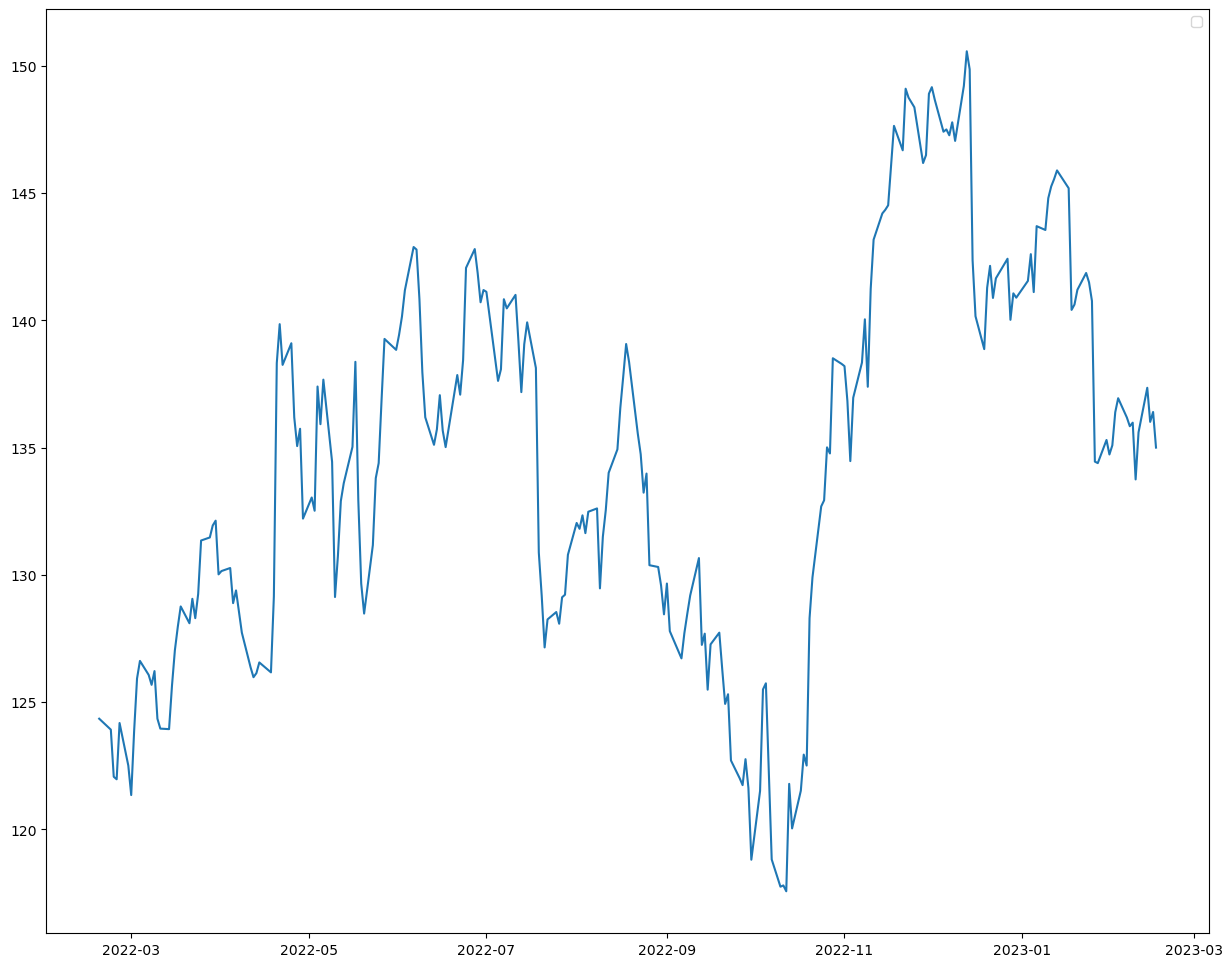

In [8]:
import pandas as pd
count=0
date=[]
for i in data['Time Series (Daily)'].keys():
    date.append(i)
    count+=1
    if count==250:
        break
close=[]
for j in date:
    close.append(data['Time Series (Daily)'][j]['4. close'])
    
date=pd.to_datetime(date)
close=[float(x) for x in close]
plt.figure(figsize=(15,12))
plt.plot(date,close)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


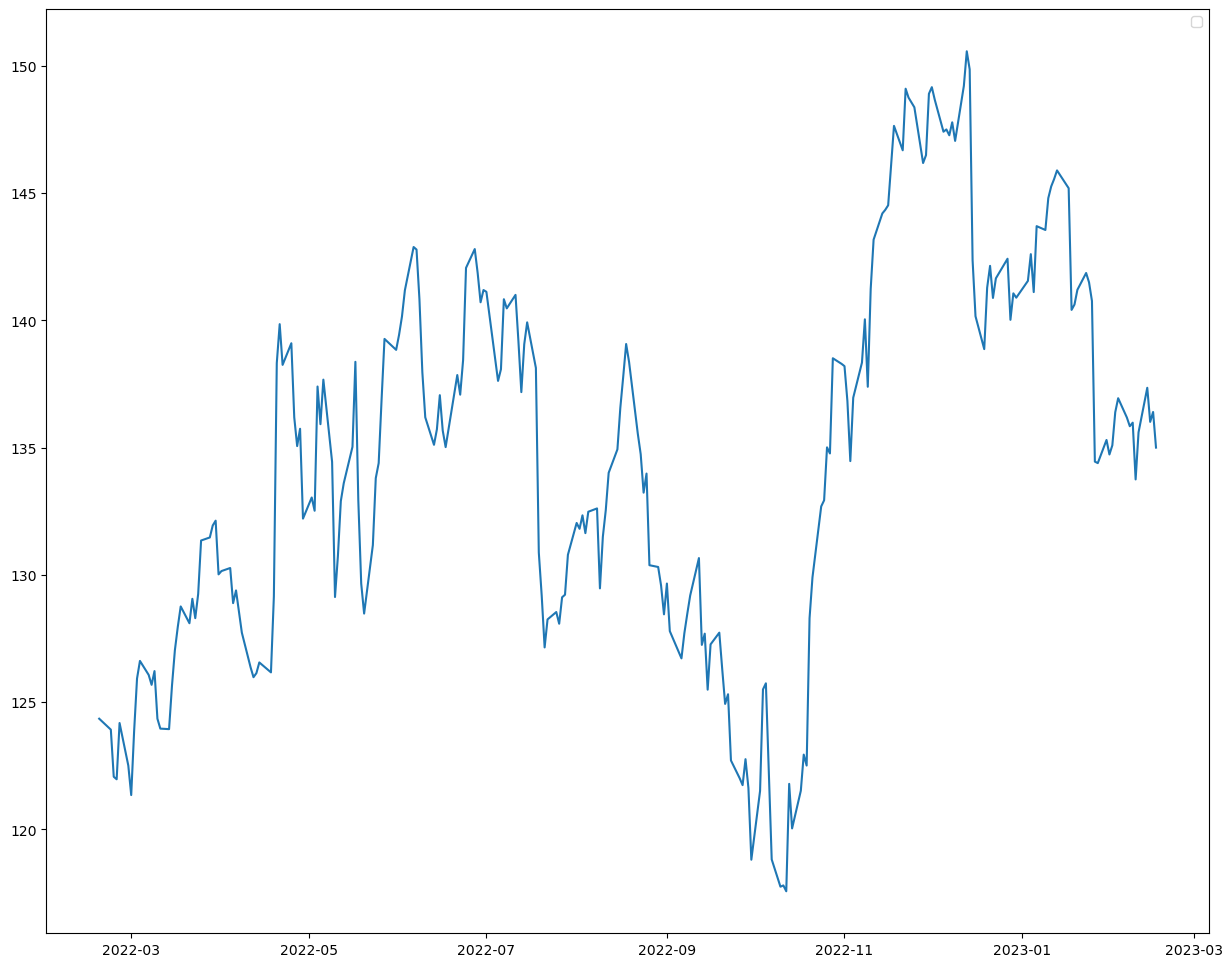

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


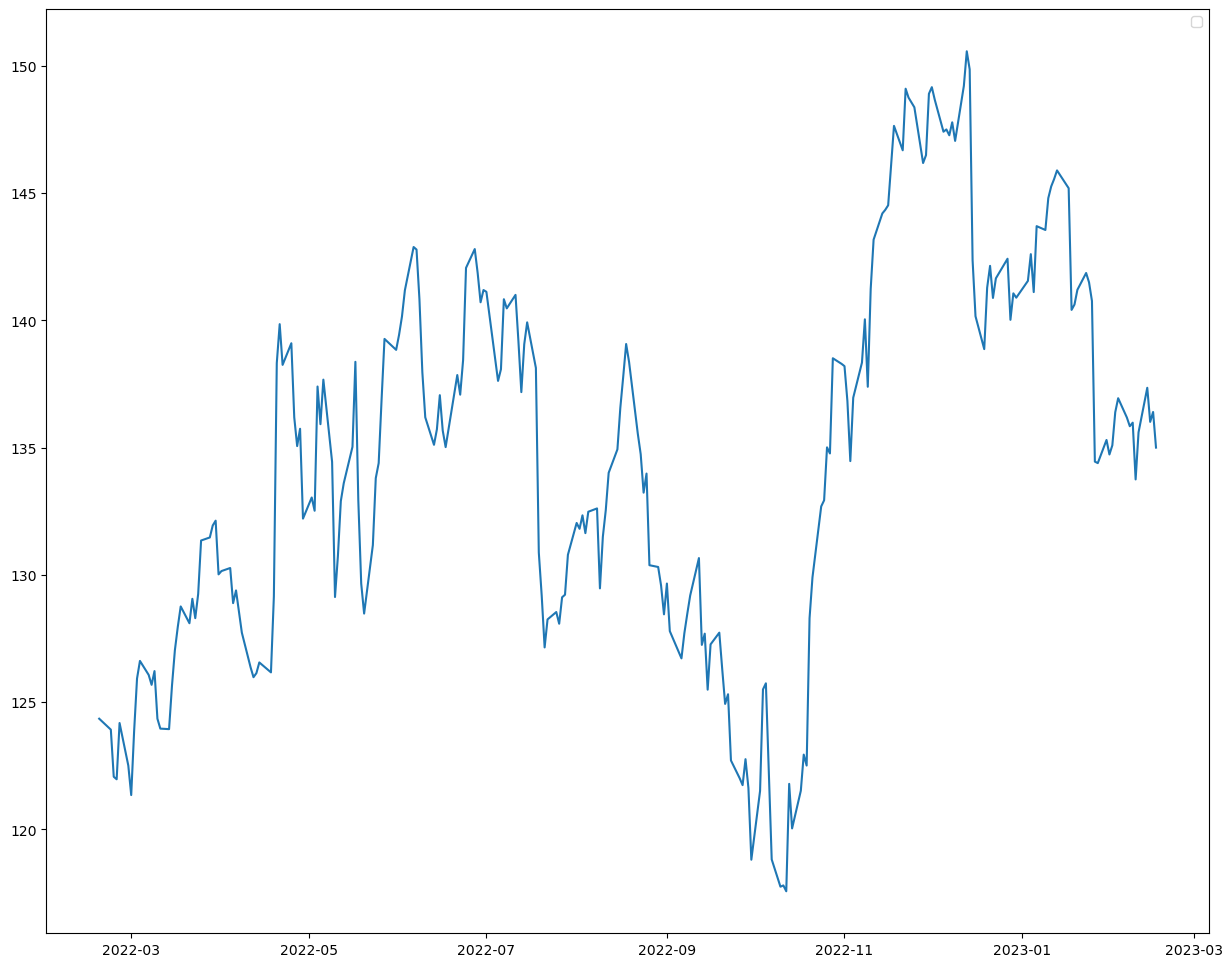

In [29]:
import pandas as pd
import numpy as np

count=0
date=[]
for i in data['Time Series (Daily)'].keys():
    date.append(i)
    count+=1
    if count==250:
        break
close=[]
for j in date:
    close.append(data['Time Series (Daily)'][j])
    
date=pd.to_datetime(date)
close=[float(x) for x in close]
plt.figure(figsize=(15,12))
plt.plot(date,close)
plt.legend()
plt.show()

In [38]:
count=0
date=[]
for i in data['Time Series (Daily)'].keys():
    date.append(i)
    count+=1
    if count==250:
        break
close=[]
for j in date:
    close.append(data['Time Series (Daily)'][j])
    

2023-02-15
2023-02-14
2023-02-13
2023-02-10
2023-02-09
2023-02-08
2023-02-07
2023-02-06
2023-02-03
2023-02-02
2023-02-01
2023-01-31
2023-01-30
2023-01-27
2023-01-26
2023-01-25
2023-01-24
2023-01-23
2023-01-20
2023-01-19
2023-01-18
2023-01-17
2023-01-13
2023-01-12
2023-01-11
2023-01-10
2023-01-09
2023-01-06
2023-01-05
2023-01-04
2023-01-03
2022-12-30
2022-12-29
2022-12-28
2022-12-27
2022-12-23
2022-12-22
2022-12-21
2022-12-20
2022-12-19
2022-12-16
2022-12-15
2022-12-14
2022-12-13
2022-12-12
2022-12-09
2022-12-08
2022-12-07
2022-12-06
2022-12-05
2022-12-02
2022-12-01
2022-11-30
2022-11-29
2022-11-28
2022-11-25
2022-11-23
2022-11-22
2022-11-21
2022-11-18
2022-11-17
2022-11-16
2022-11-15
2022-11-14
2022-11-11
2022-11-10
2022-11-09
2022-11-08
2022-11-07
2022-11-04
2022-11-03
2022-11-02
2022-11-01
2022-10-31
2022-10-28
2022-10-27
2022-10-26
2022-10-25
2022-10-24
2022-10-21
2022-10-20
2022-10-19
2022-10-18
2022-10-17
2022-10-14
2022-10-13
2022-10-12
2022-10-11
2022-10-10
2022-10-07
2022-10-06

In [3]:

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=IBM&apikey=LYWN39IXWQOEN4PW'
r = requests.get(url)
data = r.json()


In [4]:
data

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes',
  '2. Symbol': 'IBM',
  '3. Last Refreshed': '2023-02-15 16:00:01',
  '4. Output Size': 'Compact',
  '5. Time Zone': 'US/Eastern'},
 'Time Series (Daily)': {'2023-02-15': {'1. open': '135.2000',
   '2. high': '136.4500',
   '3. low': '135.0700',
   '4. close': '136.4000',
   '5. volume': '2506696'},
  '2023-02-14': {'1. open': '137.0500',
   '2. high': '137.2400',
   '3. low': '135.0500',
   '4. close': '136.0100',
   '5. volume': '3202172'},
  '2023-02-13': {'1. open': '136.0000',
   '2. high': '137.3900',
   '3. low': '135.8500',
   '4. close': '137.3500',
   '5. volume': '4403015'},
  '2023-02-10': {'1. open': '133.7800',
   '2. high': '135.7700',
   '3. low': '133.5000',
   '4. close': '135.6000',
   '5. volume': '5049571'},
  '2023-02-09': {'1. open': '134.9900',
   '2. high': '135.7300',
   '3. low': '133.3400',
   '4. close': '133.7500',
   '5. volume': '3918817'},
  '2023-02-08': {'1. open': '

In [1]:
import requests


url1 = 'https://www.alphavantage.co/query?function=OVERVIEW&symbol=IBM&apikey=demo'
r1 = requests.get(url1)
data1 = r1.json()

data1['Name']
data1['Sector']
data1['Industry']
data1['MarketCapitalization']
data1['PERatio']
data1['EPS']
data1['DividendPerShare']
data1['DividendYield']
data1['Exchange']
data1['52WeekHigh']
data1['52WeekLow']
data1['Description']


url2 = 'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers=AAPL&apikey=demo'
r2 = requests.get(url2)
data2 = r2.json()

# for i in range(5):
#     data2['feed'][i]['title']
#     data2['feed'][i]['summary']



In [2]:
data1['Description']

'International Business Machines Corporation (IBM) is an American multinational technology company headquartered in Armonk, New York, with operations in over 170 countries. The company began in 1911, founded in Endicott, New York, as the Computing-Tabulating-Recording Company (CTR) and was renamed International Business Machines in 1924. IBM is incorporated in New York. IBM produces and sells computer hardware, middleware and software, and provides hosting and consulting services in areas ranging from mainframe computers to nanotechnology. IBM is also a major research organization, holding the record for most annual U.S. patents generated by a business (as of 2020) for 28 consecutive years. Inventions by IBM include the automated teller machine (ATM), the floppy disk, the hard disk drive, the magnetic stripe card, the relational database, the SQL programming language, the UPC barcode, and dynamic random-access memory (DRAM). The IBM mainframe, exemplified by the System/360, was the dom

In [7]:
<h1>Stock symbol: {{ overview['Symbol'] }}</h1>
    <h1>Company Name: {{ overview['Name'] }}</h1>
    <h1>Sector: {{ overview['Sector'] }}</h1>
    <h1>Industry: {{ overview['Industry'] }}</h1>
    <h1>Market Capitalization: {{ overview['MarketCapitalization'] }}</h1>
    <h1>Price to Earnings Ratio: {{ overview['PERatio'] }}</h1>
    <h1>Earnings per share: {{ overview['EPS'] }}</h1>
    <h1>Dividend per share: {{ overview['DividendPerShare'] }}</h1>
    <h1>Dividend Yield: {{ overview['DividendYield'] }}</h1>
    <h1>Stock Exchange: {{ overview['Exchange'] }}</h1>
    <h1>Current Price: {{ cp }}</h1>
    <h1>Previous Close: {{ pc }}</h1>
    <h1>Open: {{ open }}</h1>
    <h1>Volume: {{ volume }}</h1>
    <h1>52 Week High: {{ overview['52WeekHigh'] }}</h1>
    <h1>52 Week Low: {{ overview['52WeekLow'] }}</h1>
    
    
    
    
    
    <p>News No.1 <a href={{news[0]['url']}}>{{news[0]['title']}}</a>  {{ news[0]['summary']}}</p>
    <p>News No.2 <a href={{news[1]['url']}}>{{news[1]['title']}}</a>  {{ news[1]['summary']}}</p>
    <p>News No.3 <a href={{news[2]['url']}}>{{news[2]['title']}}</a>  {{ news[2]['summary']}}</p>
    <p>News No.4 <a href={{news[3]['url']}}>{{news[3]['title']}}</a>  {{ news[3]['summary']}}</p>
    <p>News No.5 <a href={{news[4]['url']}}>{{news[4]['title']}}</a>  {{ news[4]['summary']}}</p>

{'title': "Ford CEO Jim Farley grapples with problems from the auto maker's past",
 'url': 'https://www.foxbusiness.com/technology/ford-ceo-jim-farley-grapples-problems-auto-makers-past',
 'time_published': '20230216T193516',
 'authors': [],
 'summary': "Jim Farley took over Ford Motor Co. more than two years ago, eager to chart the auto maker's path to an electric, high-tech future. Lately, though, problems from the past are requiring his attention.",
 'banner_image': 'https://cf-images.us-east-1.prod.boltdns.net/v1/static/694940094001/953b70e5-99d4-45b7-a61f-77cd17b18541/4fe1b425-ce10-4f73-87bb-2ae5801f41cb/1280x720/match/image.jpg?pubId=854081161001',
 'source': 'Fox Business News',
 'category_within_source': 'n/a',
 'source_domain': 'www.foxbusiness.com',
 'topics': [{'topic': 'Manufacturing', 'relevance_score': '0.333333'},
  {'topic': 'Earnings', 'relevance_score': '0.495866'},
  {'topic': 'Technology', 'relevance_score': '0.333333'},
  {'topic': 'Finance', 'relevance_score': '0.

In [28]:
import requests

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=IBM&apikey=demo'
r = requests.get(url)
data = r.json()

for i in data['Monthly Adjusted Time Series'].keys():
    print(i)

KeyError: 'Monthly Adjusted Time Series'

In [2]:
import requests

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=IBM&apikey=demo'
r = requests.get(url)
data = r.json()

for i in data['Time Series (Daily)'].keys():
    print(i)

2023-02-15
2023-02-14
2023-02-13
2023-02-10
2023-02-09
2023-02-08
2023-02-07
2023-02-06
2023-02-03
2023-02-02
2023-02-01
2023-01-31
2023-01-30
2023-01-27
2023-01-26
2023-01-25
2023-01-24
2023-01-23
2023-01-20
2023-01-19
2023-01-18
2023-01-17
2023-01-13
2023-01-12
2023-01-11
2023-01-10
2023-01-09
2023-01-06
2023-01-05
2023-01-04
2023-01-03
2022-12-30
2022-12-29
2022-12-28
2022-12-27
2022-12-23
2022-12-22
2022-12-21
2022-12-20
2022-12-19
2022-12-16
2022-12-15
2022-12-14
2022-12-13
2022-12-12
2022-12-09
2022-12-08
2022-12-07
2022-12-06
2022-12-05
2022-12-02
2022-12-01
2022-11-30
2022-11-29
2022-11-28
2022-11-25
2022-11-23
2022-11-22
2022-11-21
2022-11-18
2022-11-17
2022-11-16
2022-11-15
2022-11-14
2022-11-11
2022-11-10
2022-11-09
2022-11-08
2022-11-07
2022-11-04
2022-11-03
2022-11-02
2022-11-01
2022-10-31
2022-10-28
2022-10-27
2022-10-26
2022-10-25
2022-10-24
2022-10-21
2022-10-20
2022-10-19
2022-10-18
2022-10-17
2022-10-14
2022-10-13
2022-10-12
2022-10-11
2022-10-10
2022-10-07
2022-10-06

In [1]:
import requests